# Домашнее задание №2

## Подготовка данных

In [1]:
! pip install implicit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [3]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)
result

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
...,...,...
2037,2496,[6534178]
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ..."
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972..."
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813..."


## Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [6]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()

In [7]:
popularity

,item_id,sales_value
0,25671,20.94
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,1.98
...,...,...
89046,17991689,2.49
89047,17991691,2.49
89048,18000012,19.96
89049,18024155,3.99


In [8]:
# Возьмем логарифм чтобы сгладить разницу между числами и отнормируем для получения вероятноти

popularity['probabilities'] = np.log1p(popularity['sales_value'])
popularity['probabilities'] = popularity['probabilities']/popularity['probabilities'].sum()

In [9]:
popularity.probabilities.sum()

0.9999999999999999

In [10]:
popularity

,item_id,sales_value,probabilities
0,25671,20.94,0.000012
1,26081,0.99,0.000003
2,26093,1.59,0.000004
3,26190,1.54,0.000004
4,26355,1.98,0.000004
...,...,...,...
89046,17991689,2.49,0.000005
89047,17991691,2.49,0.000005
89048,18000012,19.96,0.000012
89049,18024155,3.99,0.000006


In [11]:
def weighted_random_recommendation(items_probabilities, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_probabilities: pd.DataFrame
        Датафрейм со столбцами item_id, probabilities. Сумма probabilities по всем товарам = 1
    """
    
    items = np.array(items_probabilities.item_id)
    prob = np.array(items_probabilities.probabilities)
    recs = np.random.choice(items, size=n, replace=False, p=prob)
    
    return recs.tolist()

In [12]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [13]:
%%time


result['weig_rand_rec'] = result['user_id'].apply(lambda x: weighted_random_recommendation(popularity, n=5))
result.head(2)

CPU times: user 3.93 s, sys: 110 ms, total: 4.04 s
Wall time: 4.08 s


In [14]:
result

,user_id,actual,weig_rand_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[13190268, 954077, 6514095, 13910404, 8353743]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[830245, 144561, 839747, 919157, 17104612]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[9677690, 941079, 1038145, 952657, 1017606]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[17170636, 12810369, 821134, 9527549, 13876853]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1049735, 10150024, 1041317, 1027478, 915816]"
...,...,...,...
2037,2496,[6534178],"[1126979, 903524, 955897, 6979536, 13095581]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[9677692, 5573314, 10285365, 969468, 1034304]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1251216, 735395, 9575602, 912684, 12457091]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[1087096, 1031193, 820321, 15452640, 12670146]"


In [15]:
result['weig_rand_rec_prec'] = result.apply(lambda x: precision_at_k(x.weig_rand_rec, x.actual, k=5), axis=1)

In [16]:
print('weighted random recommendation precision: ', result['weig_rand_rec_prec'].mean())

weighted random recommendation precision:  0.0006856023506366307


## Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [17]:
result = pd.read_csv('predictions_basic.csv')
result

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"
...,...,...,...,...,...,...,...,...
2037,2496,[6534178],"[948756, 6039678, 1044480, 1088010, 7147133]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 1098066, 6534178, 995785, 1068719]"
2038,2497,[ 1016709 9835695 1132298 16809501 845294 ...,"[1017220, 9526172, 112154, 858863, 1025755]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 1127831, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"
2039,2498,[15716530 834484 901776 914190 958382 ...,"[13511523, 15631907, 1016274, 12523694, 966472]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 1127831, 995242]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 1029743, 1068719, 1106523, 5569230]"
2040,2499,[ 867188 877580 902396 914190 951590 ...,"[968999, 2433988, 6039584, 845823, 926951]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1004906, 1081177]"


In [18]:
# Сохраняем эту колонку, так как ее не надо обрабатывать
id = result.user_id

In [19]:
id

0          1
1          3
2          6
3          7
4          8
        ... 
2037    2496
2038    2497
2039    2498
2040    2499
2041    2500
Name: user_id, Length: 2042, dtype: int64

In [20]:
# Удаляем user_id, чтобы он не изменился вместе со всеми. Потом его приклеим
result = result.drop(columns=['user_id'])

In [21]:
# Приводим все в строковый тип
res = result.applymap(lambda x: str(x))

In [22]:
# Удаляем скобки
res = res.applymap(lambda x: x[1:-1])

In [23]:
# Общим applymap не отделаемся, так как actual надо обрабатывать отдельно
#res = res.applymap(lambda x: x.split(','))

# Надо хитро обработать actual
res.actual = res.actual.apply(lambda x: x.split())
res.random_recommendation = res.random_recommendation.apply(lambda x: x.split(','))
res.popular_recommendation = res.popular_recommendation.apply(lambda x: x.split(','))
res.itemitem = res.itemitem.apply(lambda x: x.split(','))
res.cosine = res.cosine.apply(lambda x: x.split(','))
res.tfidf = res.tfidf.apply(lambda x: x.split(','))
res.own_purchases = res.own_purchases.apply(lambda x: x.split(','))

In [24]:
# Заполняем пропуски в own_purchases
for i in range(2041):
  if res.own_purchases[i] == ['']:
    res.own_purchases[i] = res.own_purchases[i-1]

#res.random_recommendation = res.random_recommendation.apply(lambda x: list(map(int, x)))
#res.popular_recommendation = res.popular_recommendation.apply(lambda x: list(map(int, x)))
#res.itemitem = res.itemitem.apply(lambda x: list(map(int, x)))
#res.cosine = res.cosine.apply(lambda x: list(map(int, x)))
#res.tfidf = res.tfidf.apply(lambda x: list(map(int, x)))

# Не будет работать, если не заполнить пропуски
#res.own_purchases = res.own_purchases.apply(lambda x: list(map(int, x)))

# Заменяет предыдущие 6 строк кода
# Не будет работать, если не заполнить пропуски в own_purchases
res = res.applymap(lambda x: list(map(int, x)))

In [25]:
res.applymap(lambda x: type(x[0]))

,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
1,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
2,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
3,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
4,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
...,...,...,...,...,...,...,...
2037,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
2038,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
2039,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>
2040,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>,<class 'int'>


In [26]:
# возвращаем колонку на место
res['user_id'] = id
cols = res.columns.to_list()
cols = cols[-1:] + cols[:-1]
res = res[cols]

In [27]:
res

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8157117, 870291, 1846901, 891748, 1038560]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1000965, 10121560, 9878622, 13512901, 13039531]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[5129567, 6555376, 9487756, 6533880, 1117945]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[15740824, 9423981, 1052258, 13986798, 1003354]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 961554, 1098066]","[1082185, 981760, 1127831, 961554, 826249]","[1082185, 1029743, 1127831, 995785, 1044078]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1964658, 954745, 976261, 7025202, 1054432]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1127831, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"
...,...,...,...,...,...,...,...,...
2037,2496,[6534178],"[948756, 6039678, 1044480, 1088010, 7147133]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 995242, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 1098066, 6534178, 995785, 1068719]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[1017220, 9526172, 112154, 858863, 1025755]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 1127831, 995242]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 1029743, 1098066, 6534178, 1127831]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[13511523, 15631907, 1016274, 12523694, 966472]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 1127831, 995242]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 981760, 1098066, 826249, 961554]","[1082185, 1029743, 1068719, 1106523, 5569230]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[968999, 2433988, 6039584, 845823, 926951]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1004906, 1081177]"


In [28]:
# Вычисляем точность предсказаний для каждого пользователя и записываем в тот же датафрейм 

res['ran_rec_prec'] = res.apply(lambda x: precision_at_k(x.random_recommendation, x.actual, k=5), axis=1)
res['pop_rec_prec'] = res.apply(lambda x: precision_at_k(x.popular_recommendation, x.actual, k=5), axis=1)
res['item_prec'] = res.apply(lambda x: precision_at_k(x.itemitem, x.actual, k=5), axis=1)
res['cosine_prec'] = res.apply(lambda x: precision_at_k(x.cosine, x.actual, k=5), axis=1)
res['tfidf_prec'] = res.apply(lambda x: precision_at_k(x.tfidf, x.actual, k=5), axis=1)
res['own_pur_prec'] = res.apply(lambda x: precision_at_k(x.own_purchases, x.actual, k=5), axis=1)

In [29]:
# Вычисляем и выводим точности предсказаний для всех пользователей

print('random recommendation precision: ', res['ran_rec_prec'].mean())
print('popular recommendation precision: ', res['pop_rec_prec'].mean())
print('itemitem precision: ', res['item_prec'].mean())
print('cosine precision: ', res['cosine_prec'].mean())
print('tfidf precision: ', res['tfidf_prec'].mean())
print('own purchases precision: ', res['own_pur_prec'].mean())

random recommendation precision:  0.0005876591576885406
popular recommendation precision:  0.15523996082272082
itemitem precision:  0.15132223310479728
cosine precision:  0.1554358472086169
tfidf precision:  0.16121449559255424
own purchases precision:  0.20122428991184846


#### Добавим weighted_random_recommendation в таблицу res и вычислим точность

In [30]:
res['weig_rand_rec'] = res['user_id'].apply(lambda x: weighted_random_recommendation(popularity, n=5))

In [31]:
res['weig_rand_rec_prec'] = res.apply(lambda x: precision_at_k(x.weig_rand_rec, x.actual, k=5), axis=1)

In [32]:
print('weighted random recommendation precision: ', res['weig_rand_rec_prec'].mean())

weighted random recommendation precision:  0.001077375122428991


Лучшее качество у own purchases, но эти рекомендации не предлагают новые товары для пользователей

## Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ- {2000, 5000, 10000} товаров. Постройте график зависимости precision@5 от топ-*
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$. Постройте график зависимости precision@5 от $K$ 

### Улучшение бейзлайнов

In [33]:
popularity = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popularity.head()

,item_id,sales_value
0,25671,20.94
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,1.98


In [34]:
top_2000 = popularity.sort_values('sales_value', ascending=False).head(2000)
top_5000 = popularity.sort_values('sales_value', ascending=False).head(5000)
top_10000 = popularity.sort_values('sales_value', ascending=False).head(10000)

top_2000['probabilities'] = np.log1p(top_2000['sales_value'])
top_2000['probabilities'] = top_2000['probabilities']/top_2000['probabilities'].sum()

top_5000['probabilities'] = np.log1p(top_5000['sales_value'])
top_5000['probabilities'] = top_5000['probabilities']/top_5000['probabilities'].sum()

top_10000['probabilities'] = np.log1p(top_10000['sales_value'])
top_10000['probabilities'] = top_10000['probabilities']/top_10000['probabilities'].sum()

In [35]:
print(top_2000.probabilities.sum())
print(top_5000.probabilities.sum())
print(top_10000.probabilities.sum())

1.0
1.0
0.9999999999999999


In [36]:
top_2000.head()

,item_id,sales_value,probabilities
55470,6534178,447799.94,0.000935
55430,6533889,40483.34,0.000762
28895,1029743,35764.66,0.000753
55465,6534166,30170.77,0.000741
34707,1082185,26029.96,0.000730


In [37]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [38]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [39]:
# popularity_recommendation не будет зависеть от выбора 2000, 5000 или 10000
# популярных товаров, так как топ рекомендаций всегда один и тот же

%%time

result['rand_rec_2000'] = result['user_id'].apply(lambda x: random_recommendation(top_2000.item_id, n=5))
result['rand_rec_5000'] = result['user_id'].apply(lambda x: random_recommendation(top_5000.item_id, n=5))
result['rand_rec_10000'] = result['user_id'].apply(lambda x: random_recommendation(top_10000.item_id, n=5))

result['weigh_rand_rec_2000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_2000, n=5))
result['weigh_rand_rec_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_5000, n=5))
result['weigh_rand_rec_10000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(top_10000, n=5))

result.head(2)

CPU times: user 2.24 s, sys: 1.57 ms, total: 2.24 s
Wall time: 2.25 s


In [40]:
# Вычисляем точность предсказаний для каждого пользователя и записываем в тот же датафрейм 

result['rr_prec_2000'] = result.apply(lambda x: precision_at_k(x.rand_rec_2000	, x.actual, k=5), axis=1)
result['rr_prec_5000'] = result.apply(lambda x: precision_at_k(x.rand_rec_5000	, x.actual, k=5), axis=1)
result['rr_prec_10000'] = result.apply(lambda x: precision_at_k(x.rand_rec_10000	, x.actual, k=5), axis=1)
result['wrr_prec_2000'] = result.apply(lambda x: precision_at_k(x.weigh_rand_rec_2000, x.actual, k=5), axis=1)
result['wrr_prec_5000'] = result.apply(lambda x: precision_at_k(x.weigh_rand_rec_5000, x.actual, k=5), axis=1)
result['wrr_prec_10000'] = result.apply(lambda x: precision_at_k(x.weigh_rand_rec_10000, x.actual, k=5), axis=1)

In [41]:
# Вычисляем и выводим точности предсказаний для всех пользователей

print('random recommend precision 2000: ', result['rr_prec_2000'].mean())
print('random recommend precision 5000: ', result['rr_prec_5000'].mean())
print('random recommend precision 10000: ', result['rr_prec_10000'].mean())
print('weigh random recommend precision 2000: ', result['wrr_prec_2000'].mean())
print('weigh random recommend precision 5000: ', result['wrr_prec_5000'].mean())
print('weigh random recommend precision 10000: ', result['wrr_prec_10000'].mean())

random recommend precision 2000:  0.008814887365328098
random recommend precision 5000:  0.003917727717923606
random recommend precision 10000:  0.0038197845249755163
weigh random recommend precision 2000:  0.007345739471106749
weigh random recommend precision 5000:  0.005484818805093042
weigh random recommend precision 10000:  0.004407443682664055


In [42]:
x = np.array([2000, 5000, 10000])
rr_prec = np.array([0.0107, 0.0049, 0.0035])
wrr_prec = np.array([0.013, 0.0074, 0.0041])

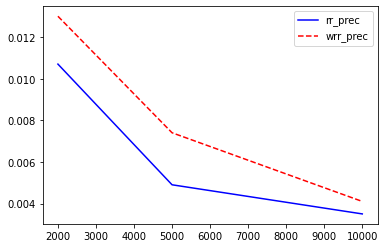

In [43]:
fig, ax = plt.subplots()
ax.plot(x, rr_prec, '-b', label='rr_prec')
ax.plot(x, wrr_prec, '--r', label='wrr_prec')
leg = ax.legend();

Видно, что точность растет с уменьшением числа товаров в топе. Взвешенные рекомендации показывают лучший результат, чем случайные

### Улучшение ItemItemRecommender

In [53]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [54]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,202291,35911
1,397896,1214994
2,420647,168661
3,480014,371107
4,545926,20134


In [55]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [56]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [58]:
%%time

model_1 = ItemItemRecommender(K=1, num_threads=4)
model_5 = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей
model_9 = ItemItemRecommender(K=9, num_threads=4)


model_1.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
model_5.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
model_9.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)

result['itemitem_1'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_1.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])

result['itemitem_5'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_5.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])
    
result['itemitem_9'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model_9.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,
                                    N=5, 
                                    filter_already_liked_items=True, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)])


CPU times: user 7.76 s, sys: 83.1 ms, total: 7.84 s
Wall time: 5.6 s


In [59]:
result['itemitem_prec_1'] = result.apply(lambda x: precision_at_k(x.itemitem_1, x.actual, k=5), axis=1)
result['itemitem_prec_5'] = result.apply(lambda x: precision_at_k(x.itemitem_5, x.actual, k=5), axis=1)
result['itemitem_prec_9'] = result.apply(lambda x: precision_at_k(x.itemitem_9, x.actual, k=5), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


In [60]:
result.head(1)

,user_id,actual,itemitem_1,itemitem_5,itemitem_9,itemitem_prec_1,itemitem_prec_5,itemitem_prec_9
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355978, 12172240, 10455984, 15926844, 12324...","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 826249, 6534178]",0.0,0.0,0.0


In [61]:
print('itemitem_1_prec: ', result['itemitem_prec_1'].mean())
print('itemitem_5_prec: ', result['itemitem_prec_5'].mean())
print('itemitem_9_prec: ', result['itemitem_prec_9'].mean())

itemitem_1_prec:  0.05412979351032487
itemitem_5_prec:  0.03320274240940271
itemitem_9_prec:  0.030362389813908063


In [63]:
x = np.array([1, 5, 9])
itemitem = np.array([0.054, 0.033, 0.03])

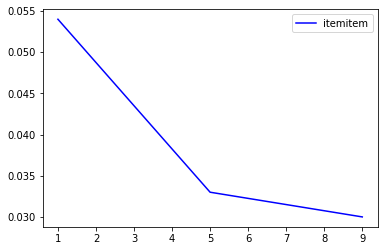

In [64]:
fig, ax = plt.subplots()
ax.plot(x, itemitem, '-b', label='itemitem')
leg = ax.legend();

С увеличением числа соседей точность снижается, но рекомендации более разнообразные